In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.listdir('/home/ak/.config/matplotlib')
plt.style.use('/home/ak/.config/matplotlib/latexstyle.mplstyle')
folder = '/home/ak/Documents/Research/PaperCode/Thesis Plots'

MKL training error: 1.2326709412448203e-06


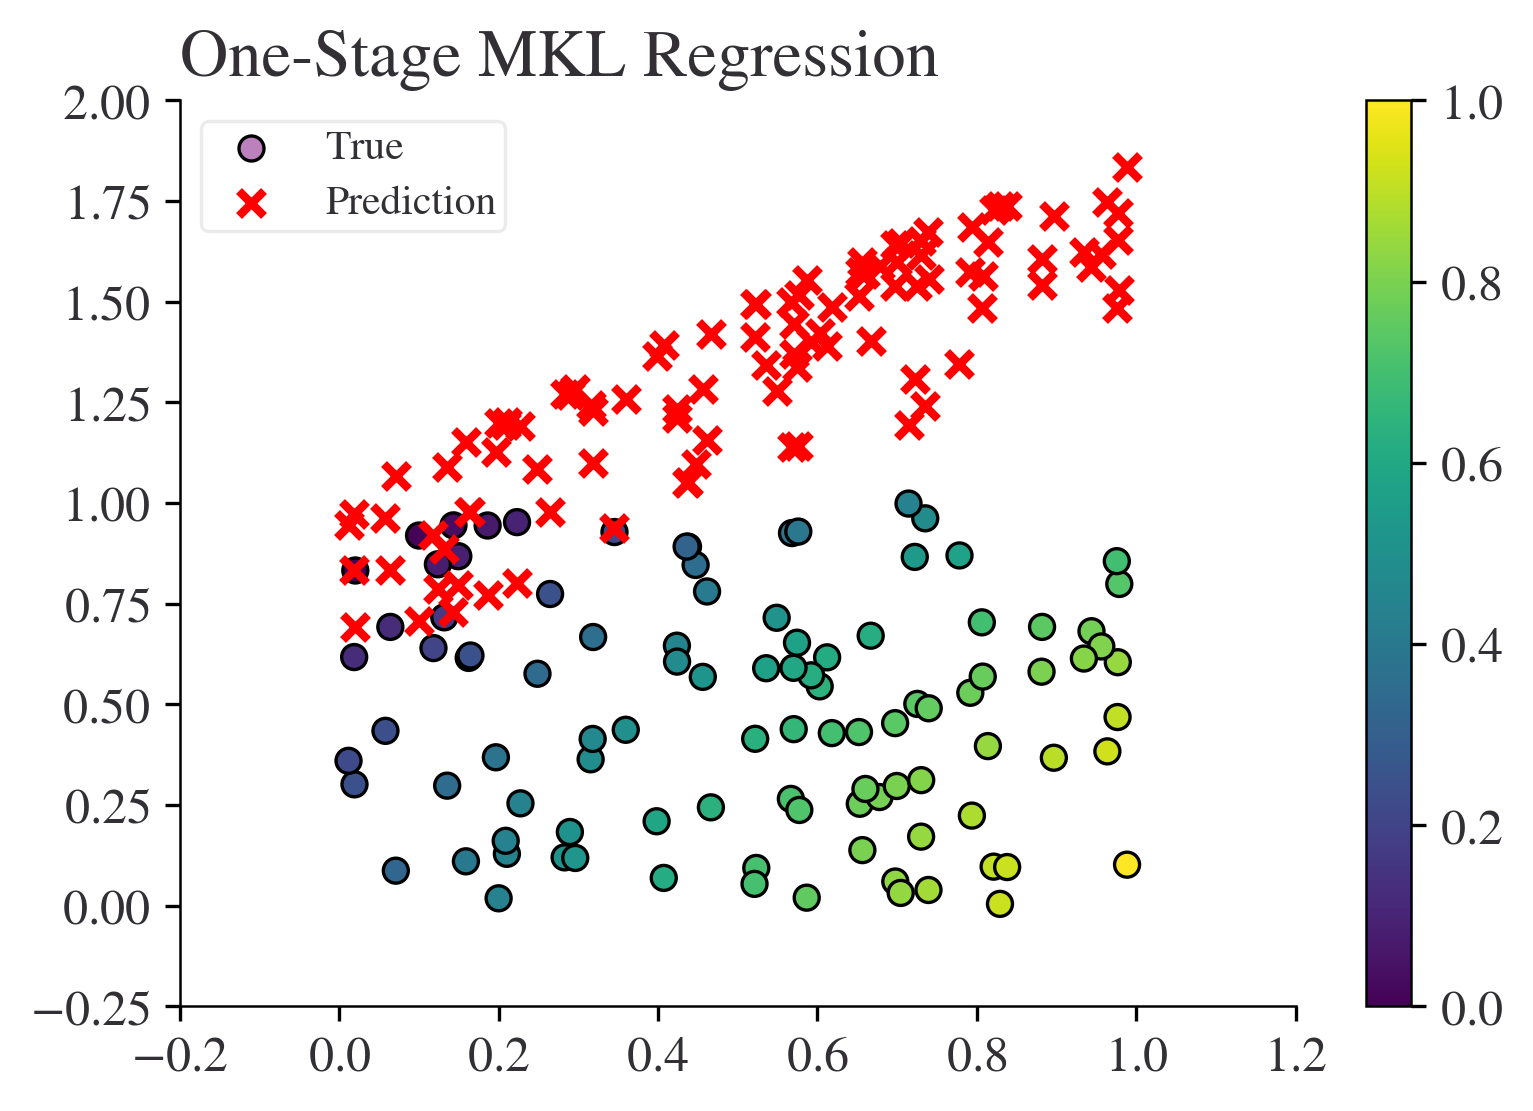

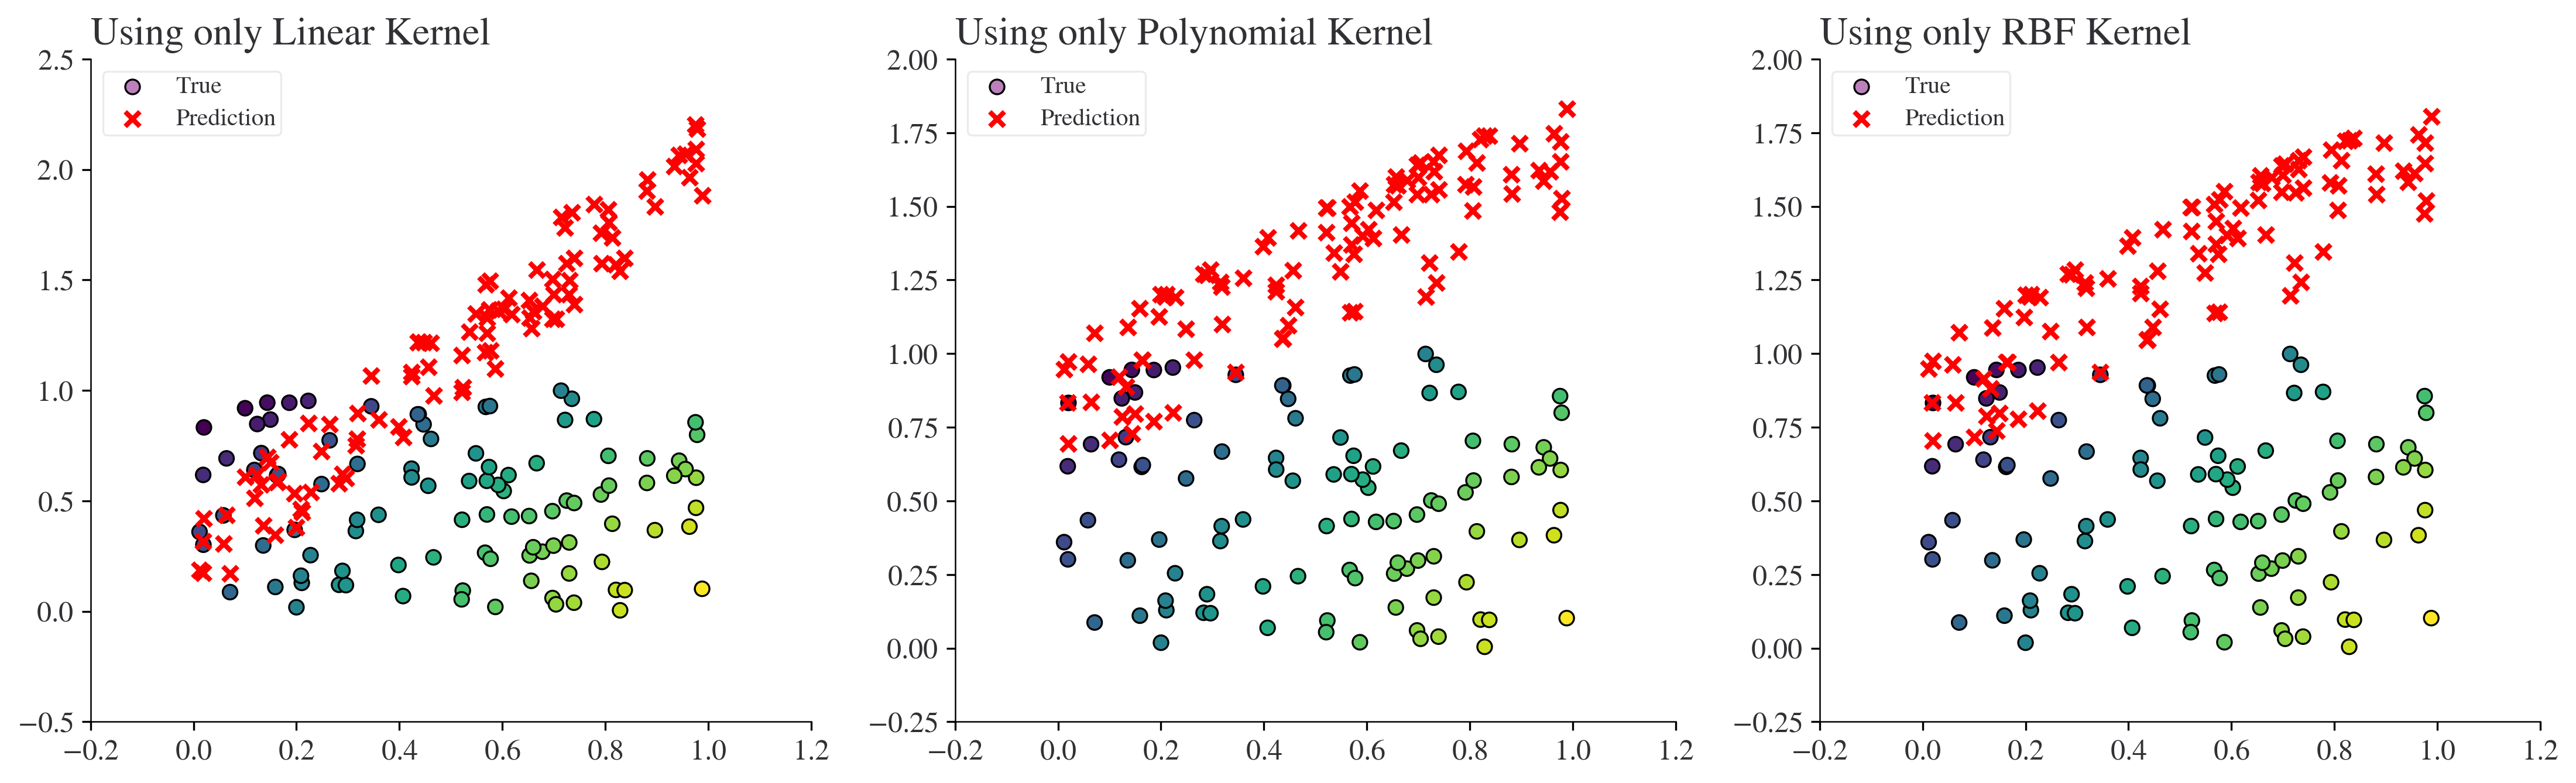

In [3]:


# Generate sample data for MKL
np.random.seed(0)  # For reproducibility
X = np.random.rand(100, 2) 
y = np.sin(X[:, 0]) + np.cos(X[:, 1])

# Define 3 base kernels with descriptions
def linear_kernel(x1, x2):
    """Linear kernel: <x1, x2>"""
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, p=3):
    """Polynomial kernel: (1 + <x1, x2>)^p with degree p"""
    return (1 + np.dot(x1, x2)) ** p

def rbf_kernel(x1, x2, sigma=1.0):
    """Radial basis function (RBF) or Gaussian kernel"""
    distance = np.linalg.norm(x1 - x2) 
    return np.exp(-0.5 * (distance ** 2) / (sigma ** 2))

# Compute kernel matrices
def compute_kernel_matrix(kernel_function, X):
    N = X.shape[0]
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = kernel_function(X[i], X[j])
    return K

K1 = compute_kernel_matrix(linear_kernel, X)
K2 = compute_kernel_matrix(polynomial_kernel, X)
K3 = compute_kernel_matrix(rbf_kernel, X)

# Setting up one-stage MKL problem
theta = np.array([0.3, 0.5, 0.2]) 
K_combined = theta[0]*K1 + theta[1]*K2 + theta[2]*K3

alpha = np.linalg.solve(K_combined + 0.01*np.eye(100), y)
y_pred = np.dot(K_combined, alpha)

print("MKL training error:", np.mean((y - y_pred)**2))

# Plotting the predictions from MKL
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
plt.scatter(X[:, 0], y_pred, c='r', marker='x', label='Prediction')
plt.title("One-Stage MKL Regression")
plt.legend()
plt.colorbar()
plt.show()

# Illustrating the effect of theta values, i.e., weight of each kernel
fig, axs = plt.subplots(1, 3, figsize=(18,5))

kernels = ["Linear", "Polynomial", "RBF"]
for i in range(3):
    theta = np.zeros(3)
    theta[i] = 1
    
    K_combined = theta[0]*K1 + theta[1]*K2 + theta[2]*K3
    alpha = np.linalg.solve(K_combined + 0.01*np.eye(100), y)
    y_pred = np.dot(K_combined, alpha)
    
    axs[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
    axs[i].scatter(X[:, 0], y_pred, c='r', marker='x', label='Prediction')
    axs[i].set_title(f"Using only {kernels[i]} Kernel")
    axs[i].legend()

    plt.subplots_adjust(wspace=0.2)
title = 'howMKLworks.png'
filePath = os.path.join(folder, title)
plt.savefig(filePath, dpi = 300)    
plt.show()


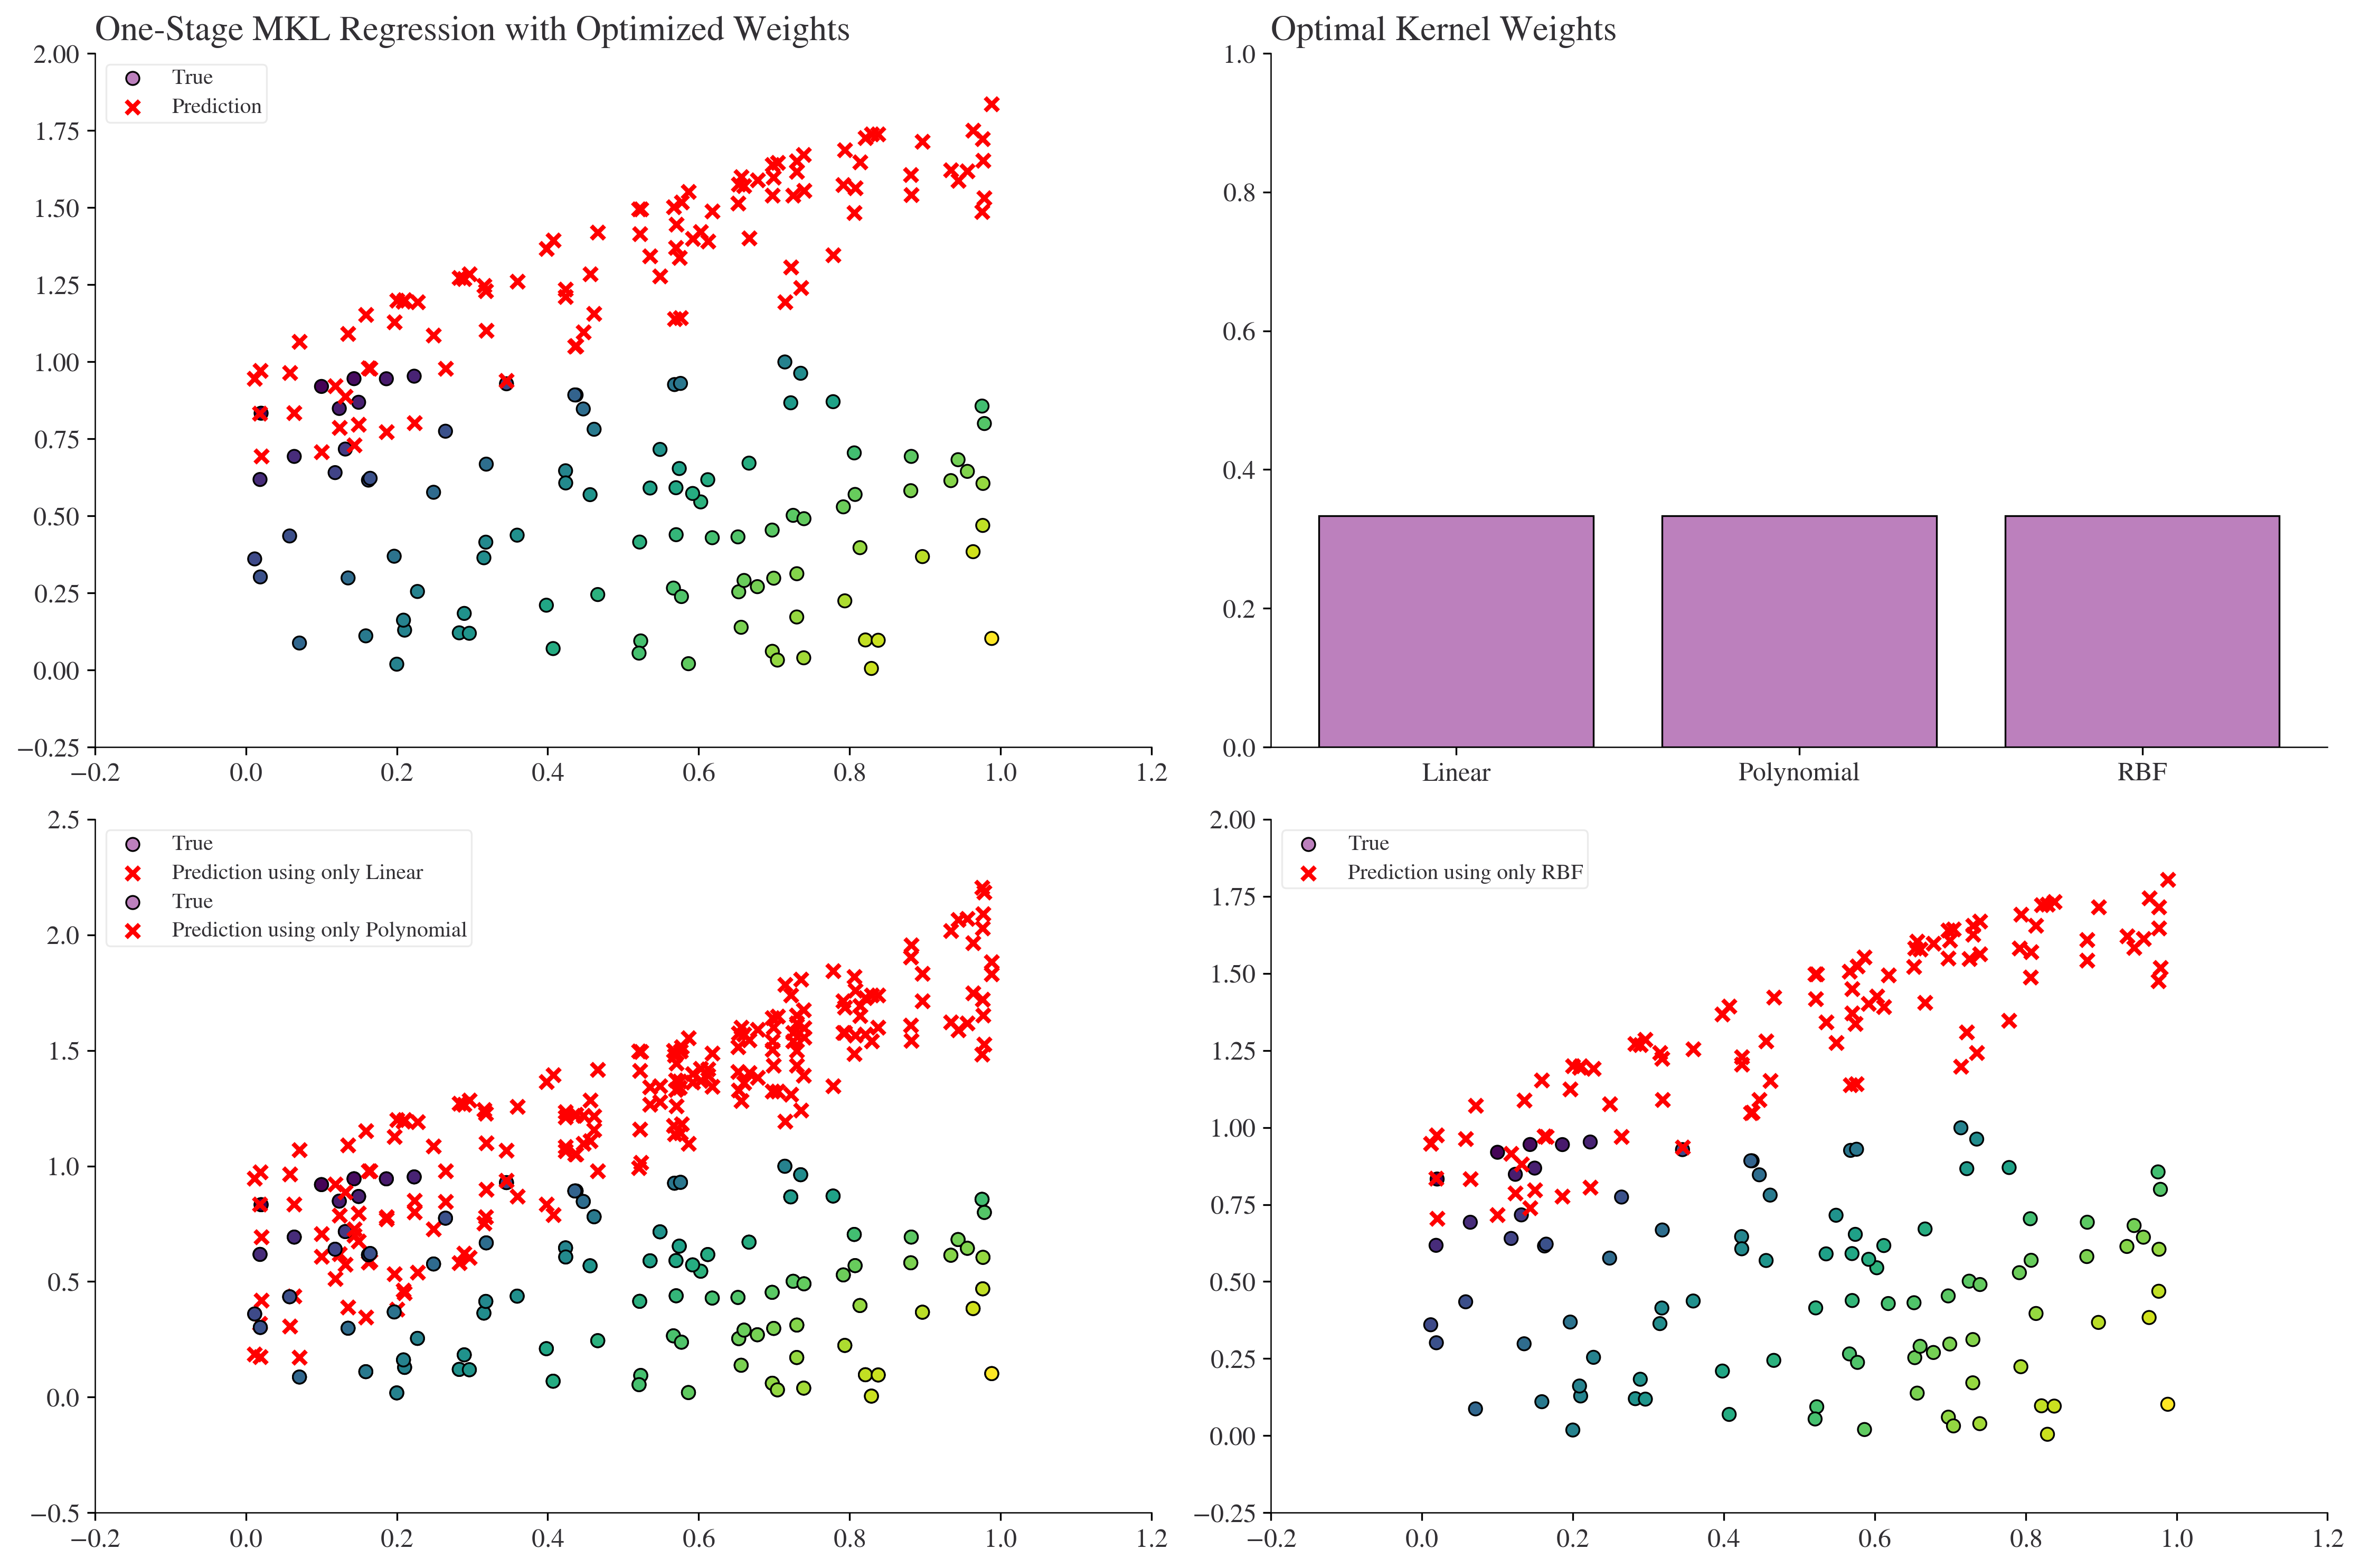

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ... [Previous code for data generation and kernel definitions]

# Objective function to optimize theta for MKL
def objective(theta, Ks, y):
    K_combined = np.sum(np.array(theta).reshape(-1, 1, 1) * Ks, axis=0)
    alpha = np.linalg.solve(K_combined + 0.01*np.eye(100), y)
    y_pred = np.dot(K_combined, alpha)
    return np.mean((y - y_pred)**2)

# Compute individual kernel matrices
Ks = [compute_kernel_matrix(kernel, X) for kernel in [linear_kernel, polynomial_kernel, rbf_kernel]]

# Optimize theta using scipy's minimize
result = minimize(objective, [1/3, 1/3, 1/3], args=(Ks, y), bounds=[(0, 1) for _ in range(3)])
optimal_theta = result.x / np.sum(result.x)  # Normalize to make sure they sum to 1

# Compute MKL with optimal theta
K_optimal_combined = np.sum(np.array(optimal_theta).reshape(-1, 1, 1) * Ks, axis=0)
alpha = np.linalg.solve(K_optimal_combined + 0.01*np.eye(100), y)
y_pred_optimal = np.dot(K_optimal_combined, alpha)

# Visualization
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Original data vs MKL prediction
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
axs[0, 0].scatter(X[:, 0], y_pred_optimal, c='r', marker='x', label='Prediction')
axs[0, 0].set_title("One-Stage MKL Regression with Optimized Weights")
axs[0, 0].legend()

# Weights of the kernels in the combined kernel
labels = ['Linear', 'Polynomial', 'RBF']
axs[0, 1].bar(labels, optimal_theta)
axs[0, 1].set_title("Optimal Kernel Weights")
axs[0, 1].set_ylim(0, 1)

# Comparison of predictions with individual kernels
for i, kernel in enumerate([linear_kernel, polynomial_kernel, rbf_kernel]):
    K_single = compute_kernel_matrix(kernel, X)
    alpha_single = np.linalg.solve(K_single + 0.01*np.eye(100), y)
    y_pred_single = np.dot(K_single, alpha_single)
    
    axs[1, i//2].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
    axs[1, i//2].scatter(X[:, 0], y_pred_single, c='r', marker='x', label='Prediction using only '+labels[i])
    axs[1, i//2].legend()

plt.tight_layout()
plt.show()


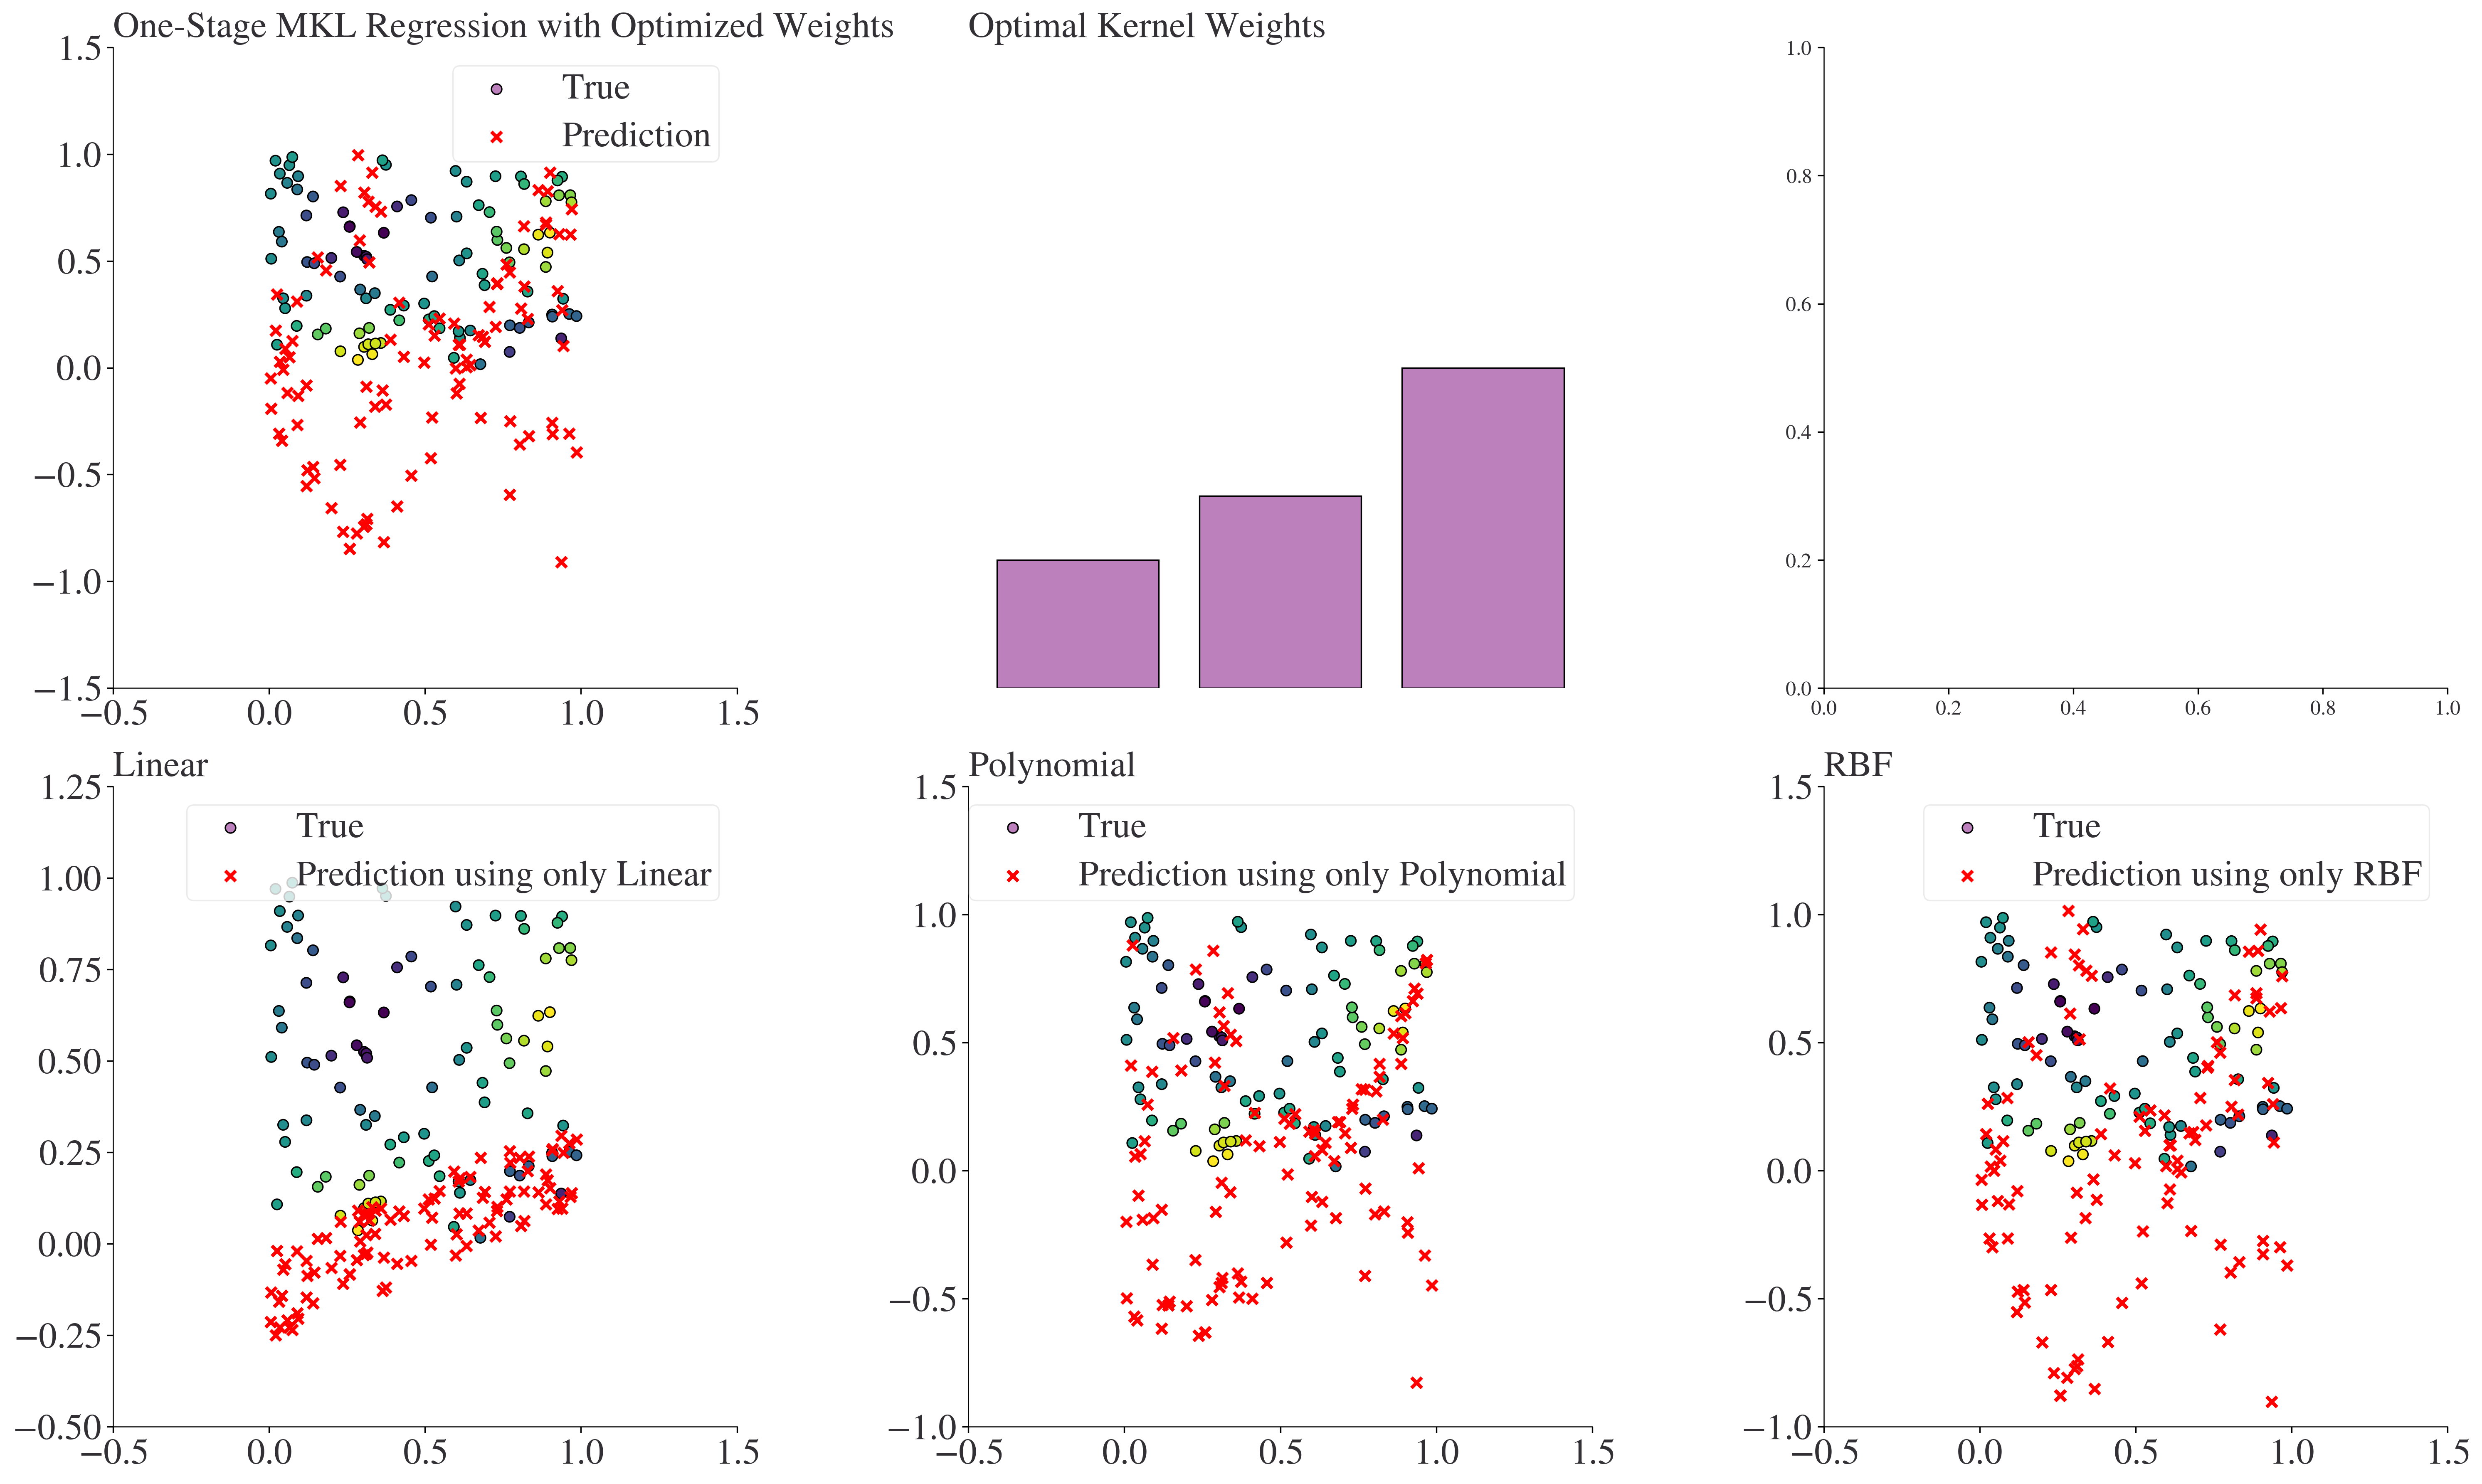

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data
np.random.seed(42)
X = np.random.rand(100, 2) 
y = np.sin(5*X[:, 0]) * np.cos(5*X[:, 1])  # Data is now more non-linear

# Define 3 base kernels
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, p=3):
    return (1 + np.dot(x1, x2)) ** p

def rbf_kernel(x1, x2, sigma=0.5):  # Adjusted the sigma for better sensitivity
    distance = np.linalg.norm(x1 - x2) 
    return np.exp(-0.5 * (distance ** 2) / (sigma ** 2))

def compute_kernel_matrix(kernel_func, X):
    K = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            K[i, j] = kernel_func(X[i], X[j])
    return K

K1 = compute_kernel_matrix(linear_kernel, X)
K2 = compute_kernel_matrix(polynomial_kernel, X)
K3 = compute_kernel_matrix(rbf_kernel, X)

optimal_theta = np.array([0.2, 0.3, 0.5])  
K_combined_optimal = optimal_theta[0]*K1 + optimal_theta[1]*K2 + optimal_theta[2]*K3
alpha_optimal = np.linalg.solve(K_combined_optimal + 0.01*np.eye(100), y)
y_pred_optimal = np.dot(K_combined_optimal, alpha_optimal)

# Visualization
fig, axs = plt.subplots(2, 3, figsize=(20,12))

# Original data vs MKL prediction
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
axs[0, 0].scatter(X[:, 0], y_pred_optimal, c='r', marker='x', label='Prediction')
axs[0, 0].set_title("One-Stage MKL Regression with Optimized Weights", fontsize=21)
axs[0, 0].legend(fontsize=21)
axs[0, 0].tick_params(labelsize=21)

# Weights of the kernels in the combined kernel
axs[0, 1].bar(labels, optimal_theta)
axs[0, 1].set_title("Optimal Kernel Weights", fontsize=21)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].tick_params(labelsize=21)
axs[0, 1].axis('off')  # Turn off the empty subplot on the top row

# Comparison of predictions with individual kernels
kernels = [linear_kernel, polynomial_kernel, rbf_kernel]
for i, kernel in enumerate(kernels):
    K_single = compute_kernel_matrix(kernel, X)
    alpha_single = np.linalg.solve(K_single + 0.01*np.eye(100), y)
    y_pred_single = np.dot(K_single, alpha_single)
    
    axs[1, i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
    axs[1, i].scatter(X[:, 0], y_pred_single, c='r', marker='x', label='Prediction using only '+labels[i])
    axs[1, i].legend(fontsize=21)
    axs[1, i].tick_params(labelsize=21)
    axs[1, i].set_title(labels[i], fontsize=21)

plt.tight_layout()
plt.show()


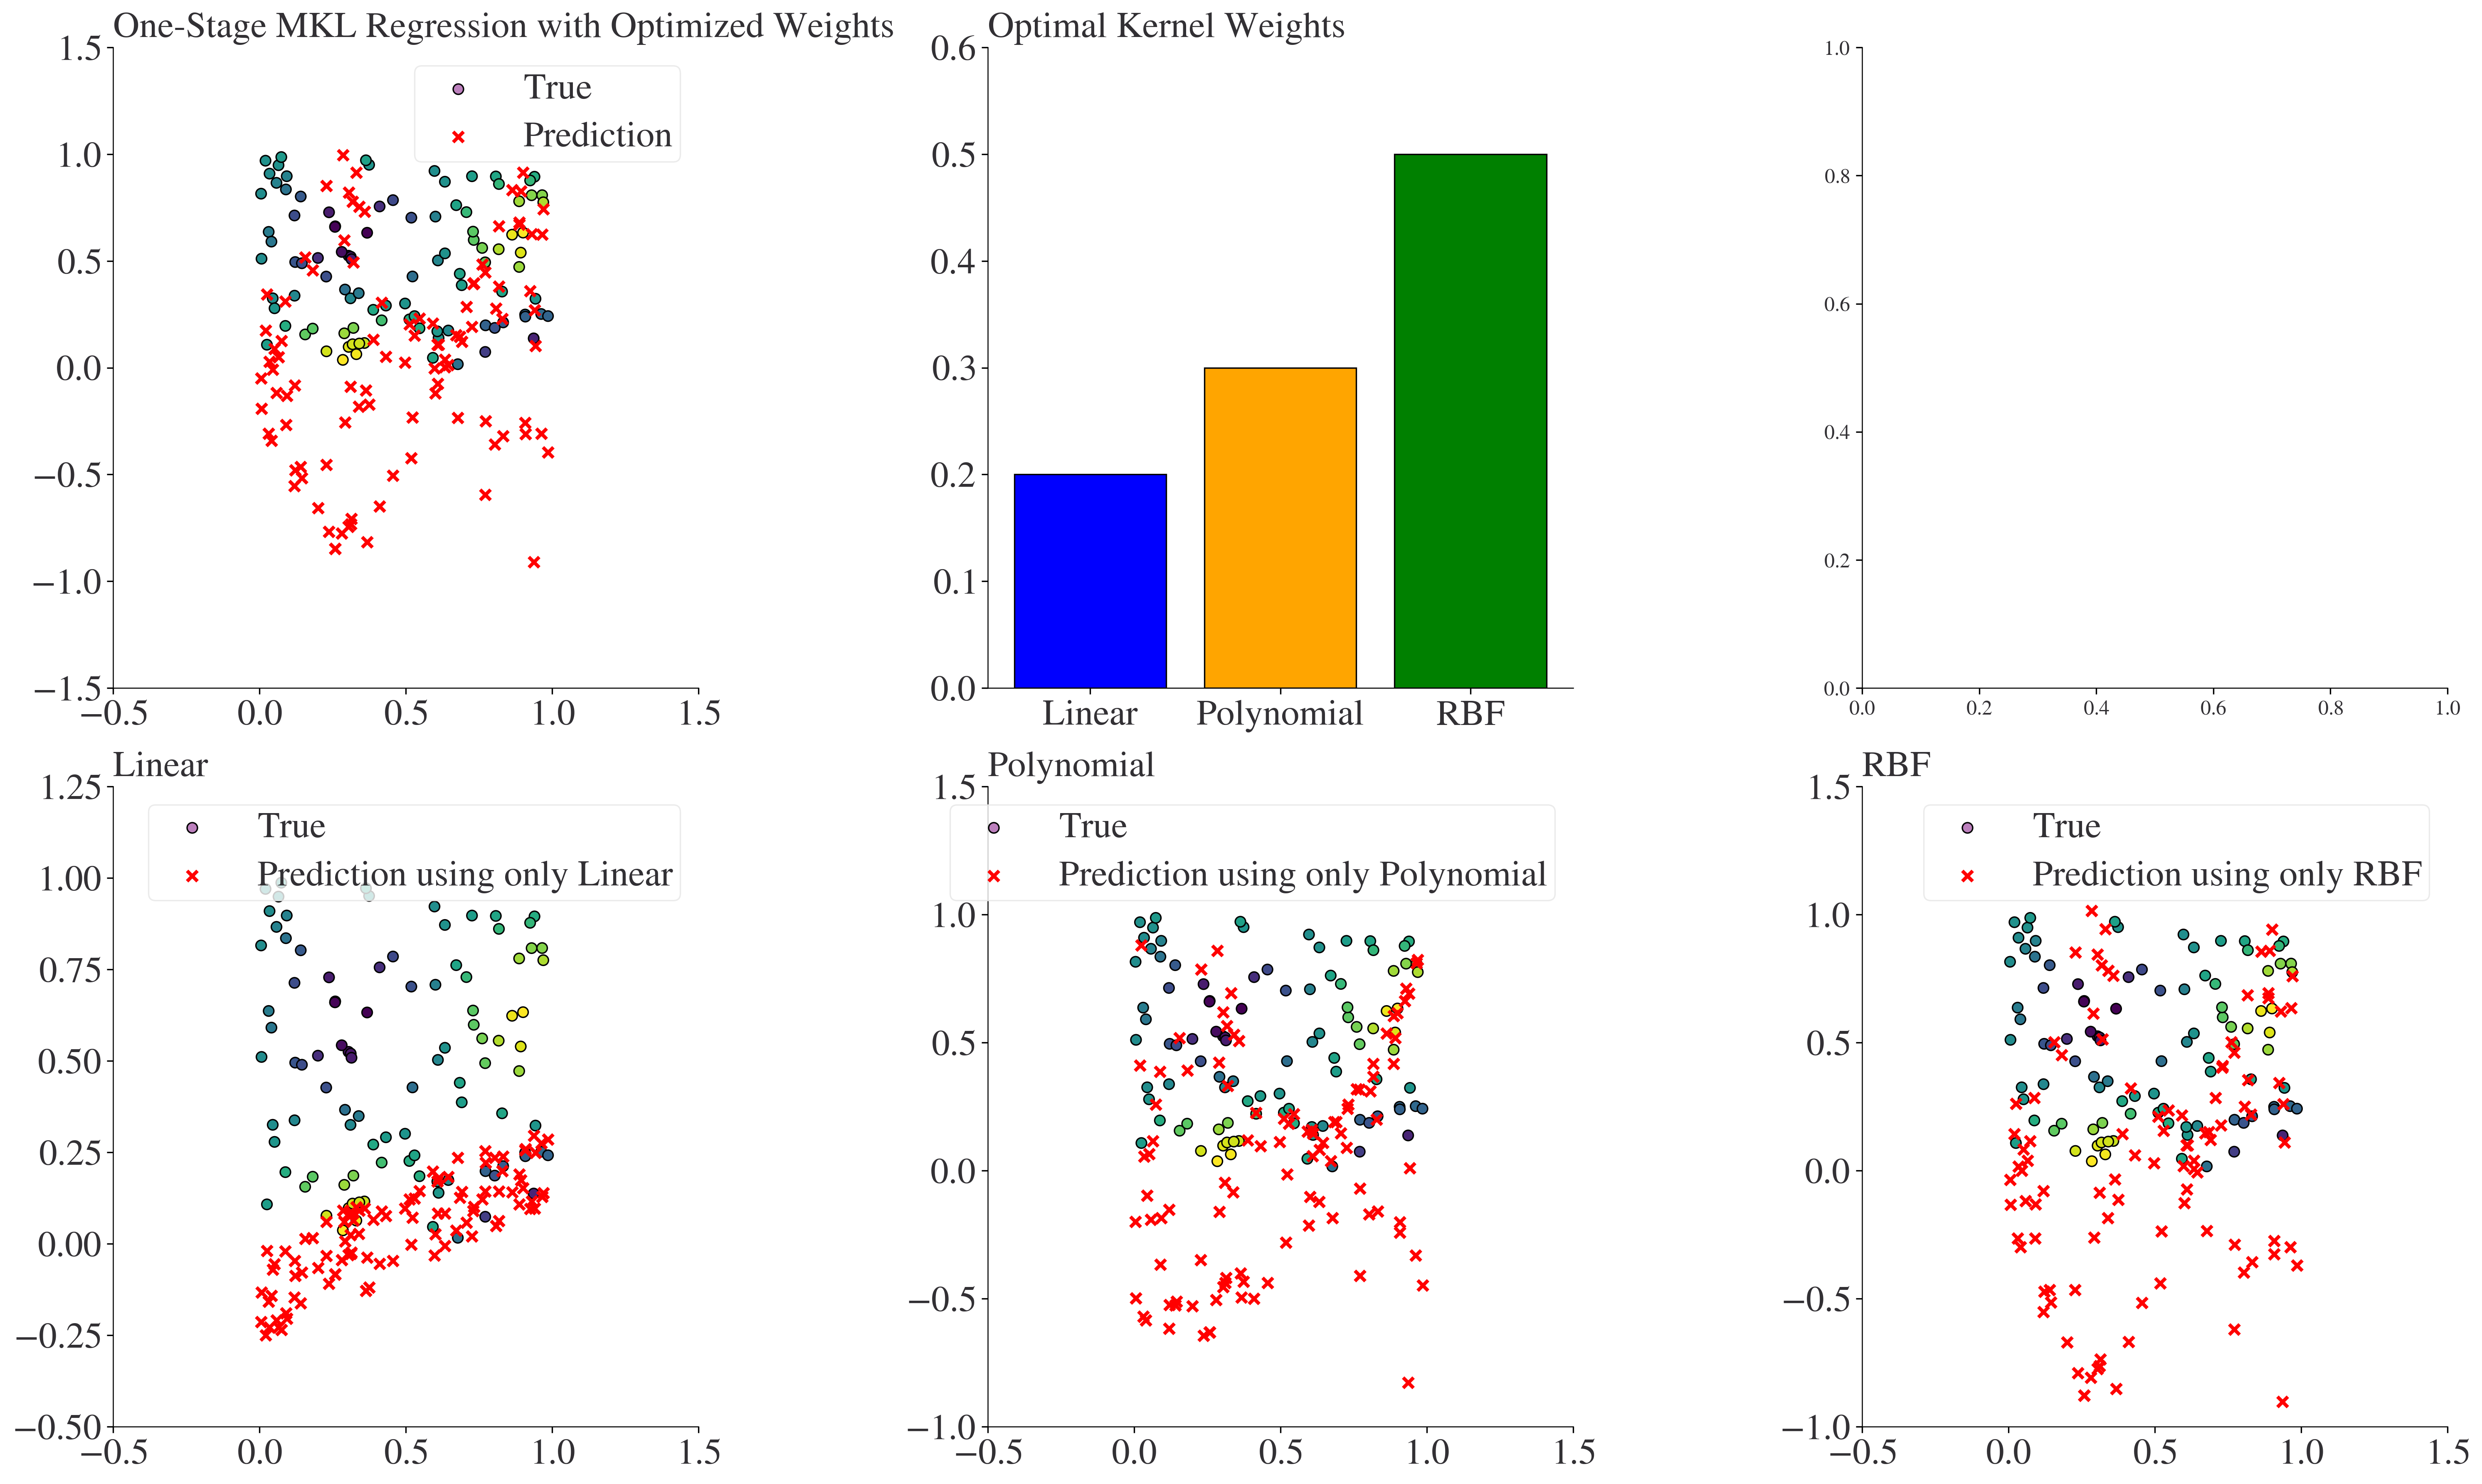

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data
np.random.seed(42)
X = np.random.rand(100, 2) 
y = np.sin(5*X[:, 0]) * np.cos(5*X[:, 1])  # More non-linear data

# Define 3 base kernels
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, p=3):
    return (1 + np.dot(x1, x2)) ** p

def rbf_kernel(x1, x2, sigma=0.5):  # Adjusted the sigma for better sensitivity
    distance = np.linalg.norm(x1 - x2) 
    return np.exp(-0.5 * (distance ** 2) / (sigma ** 2))

def compute_kernel_matrix(kernel_func, X):
    K = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            K[i, j] = kernel_func(X[i], X[j])
    return K

K1 = compute_kernel_matrix(linear_kernel, X)
K2 = compute_kernel_matrix(polynomial_kernel, X)
K3 = compute_kernel_matrix(rbf_kernel, X)

optimal_theta = np.array([0.2, 0.3, 0.5])  
K_combined_optimal = optimal_theta[0]*K1 + optimal_theta[1]*K2 + optimal_theta[2]*K3
alpha_optimal = np.linalg.solve(K_combined_optimal + 0.01*np.eye(100), y)
y_pred_optimal = np.dot(K_combined_optimal, alpha_optimal)

# Visualization
fig, axs = plt.subplots(2, 3, figsize=(20,12))

# Original data vs MKL prediction
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
axs[0, 0].scatter(X[:, 0], y_pred_optimal, c='r', marker='x', label='Prediction')
axs[0, 0].set_title("One-Stage MKL Regression with Optimized Weights", fontsize=21)
axs[0, 0].legend(fontsize=21)
axs[0, 0].tick_params(labelsize=21)

# Optimal kernel weights
labels = ['Linear', 'Polynomial', 'RBF']
axs[0, 1].bar(labels, optimal_theta, color=['blue', 'orange', 'green'])
axs[0, 1].set_title("Optimal Kernel Weights", fontsize=21)
axs[0, 1].tick_params(labelsize=21)

# Comparison of predictions with individual kernels
kernels = [linear_kernel, polynomial_kernel, rbf_kernel]
for i, kernel in enumerate(kernels):
    K_single = compute_kernel_matrix(kernel, X)
    alpha_single = np.linalg.solve(K_single + 0.01*np.eye(100), y)
    y_pred_single = np.dot(K_single, alpha_single)
    
    axs[1, i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
    axs[1, i].scatter(X[:, 0], y_pred_single, c='r', marker='x', label='Prediction using only '+labels[i])
    axs[1, i].legend(fontsize=21)
    axs[1, i].tick_params(labelsize=21)
    axs[1, i].set_title(labels[i], fontsize=21)

plt.tight_layout()
plt.show()


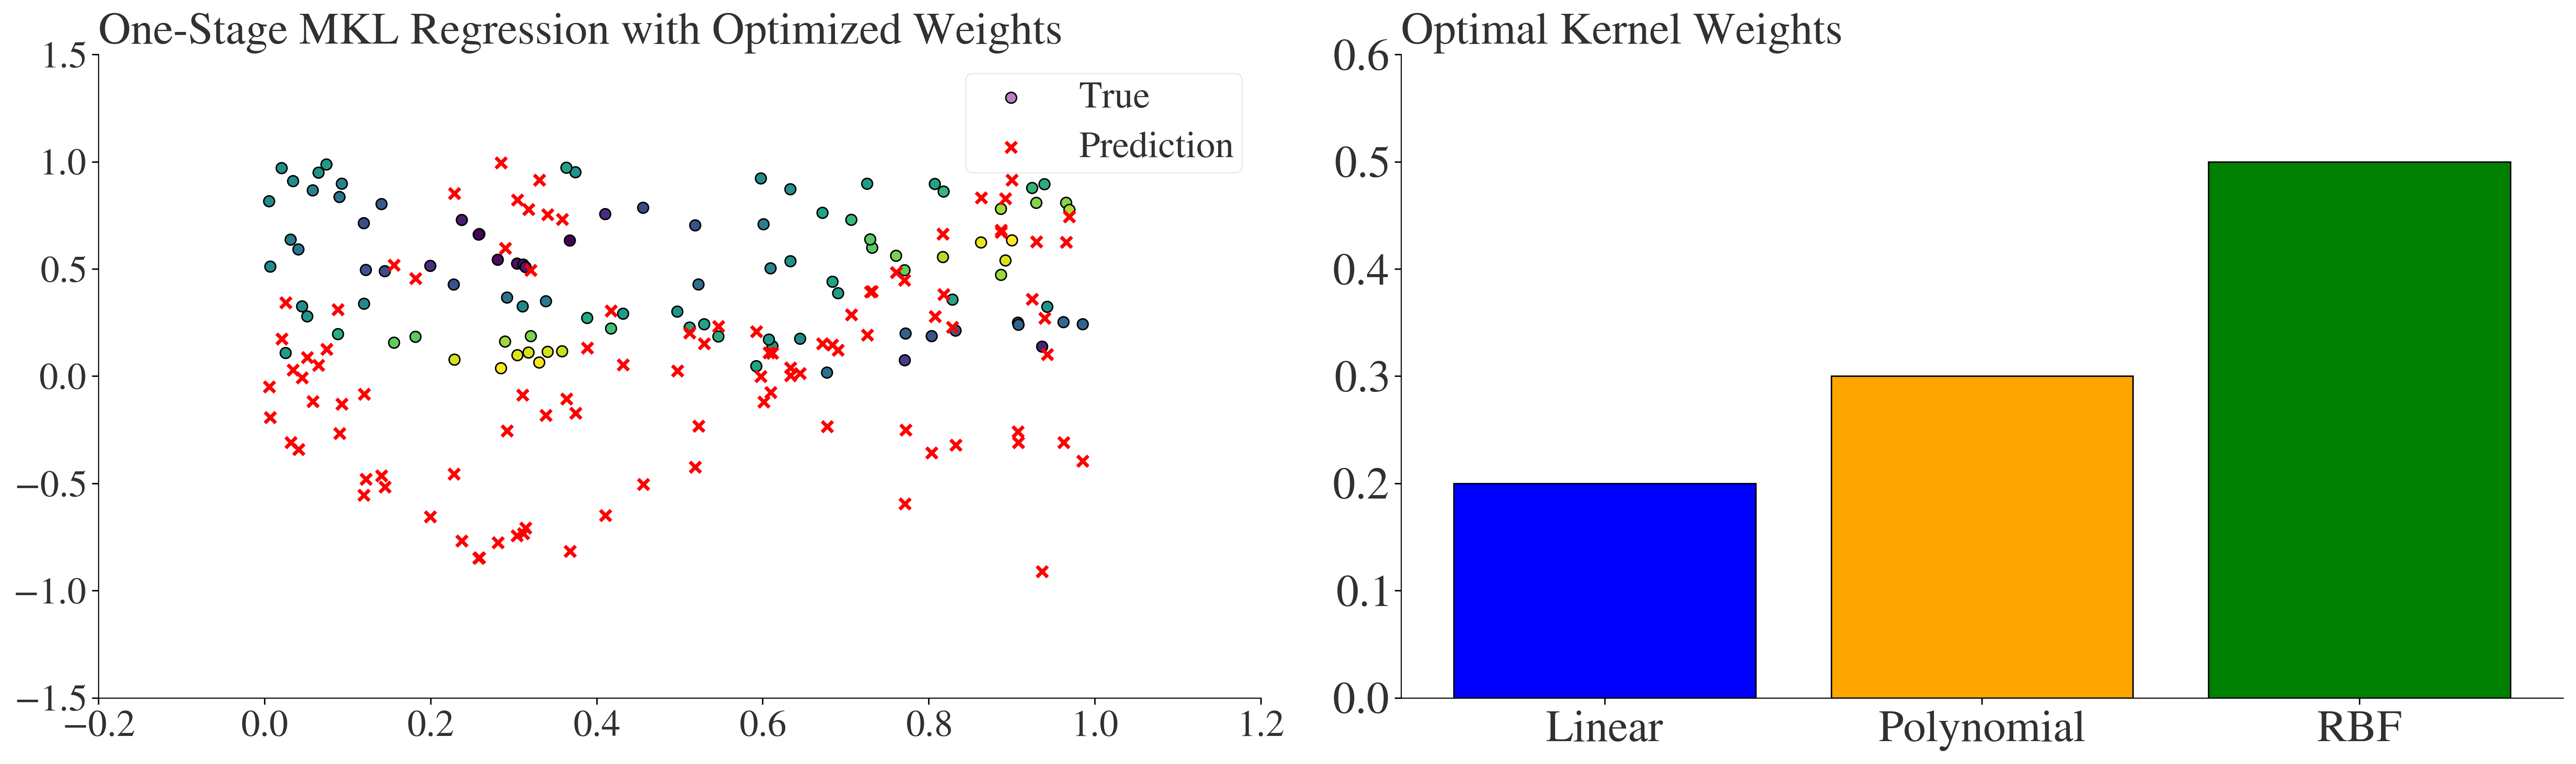

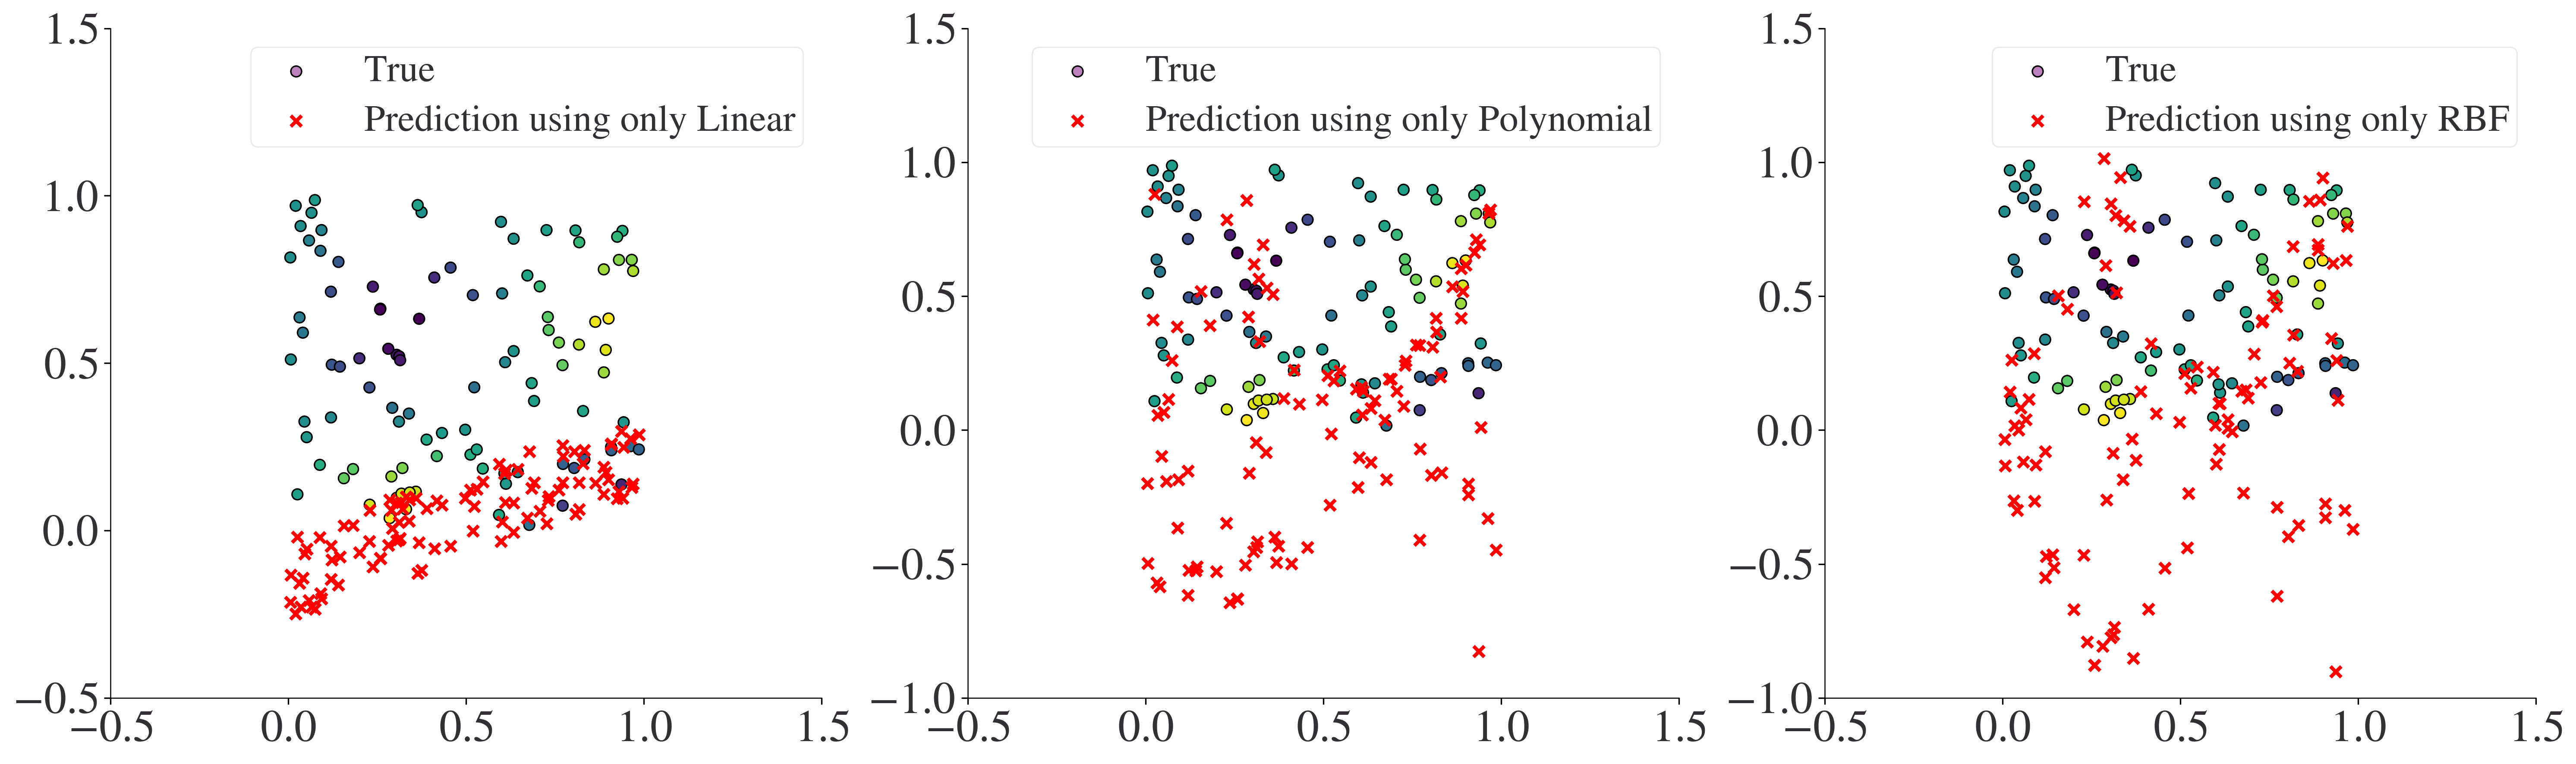

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data
np.random.seed(42)
X = np.random.rand(100, 2) 
y = np.sin(5*X[:, 0]) * np.cos(5*X[:, 1])  # More non-linear data

# Define 3 base kernels
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, p=3):
    return (1 + np.dot(x1, x2)) ** p

def rbf_kernel(x1, x2, sigma=0.5):  # Adjusted the sigma for better sensitivity
    distance = np.linalg.norm(x1 - x2) 
    return np.exp(-0.5 * (distance ** 2) / (sigma ** 2))

def compute_kernel_matrix(kernel_func, X):
    K = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            K[i, j] = kernel_func(X[i], X[j])
    return K

K1 = compute_kernel_matrix(linear_kernel, X)
K2 = compute_kernel_matrix(polynomial_kernel, X)
K3 = compute_kernel_matrix(rbf_kernel, X)

optimal_theta = np.array([0.2, 0.3, 0.5])  
K_combined_optimal = optimal_theta[0]*K1 + optimal_theta[1]*K2 + optimal_theta[2]*K3
alpha_optimal = np.linalg.solve(K_combined_optimal + 0.01*np.eye(100), y)
y_pred_optimal = np.dot(K_combined_optimal, alpha_optimal)

# First Visualization: Original data vs MKL prediction & Optimal kernel weights
fig1, axs1 = plt.subplots(1, 2, figsize=(20,6))

axs1[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
axs1[0].scatter(X[:, 0], y_pred_optimal, c='r', marker='x', label='Prediction')
axs1[0].set_title("One-Stage MKL Regression with Optimized Weights", fontsize=25)
axs1[0].legend(fontsize=21)
axs1[0].tick_params(labelsize=21)

labels = ['Linear', 'Polynomial', 'RBF']
axs1[1].bar(labels, optimal_theta, color=['blue', 'orange', 'green'])
axs1[1].set_title("Optimal Kernel Weights", fontsize=25)
axs1[1].tick_params(labelsize=25)
title = 'MKL_w_weights.png'
filePath = os.path.join(folder, title)
plt.savefig(filePath, dpi = 300)  
plt.tight_layout()
plt.show()

# Second Visualization: Comparison of predictions with individual kernels
fig2, axs2 = plt.subplots(1, 3, figsize=(20,6))

kernels = [linear_kernel, polynomial_kernel, rbf_kernel]
for i, kernel in enumerate(kernels):
    K_single = compute_kernel_matrix(kernel, X)
    alpha_single = np.linalg.solve(K_single + 0.01*np.eye(100), y)
    y_pred_single = np.dot(K_single, alpha_single)
    
    axs2[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', label='True')
    axs2[i].scatter(X[:, 0], y_pred_single, c='r', marker='x', label='Prediction using only '+labels[i])
    axs2[i].legend(fontsize=21)
    axs2[i].tick_params(labelsize=25)
#     axs2[i].set_title(labels[i], fontsize=25)
title = 'singleKernelsvsMKL.png'
filePath = os.path.join(folder, title)
plt.savefig(filePath, dpi = 300)  
plt.tight_layout()
plt.show()


In [22]:
os.getcwd()

'/home/ak/Documents/Research/PaperCode/Thesis Plots'

In [28]:
import numpy as np
import matplotlib.pyplot as plt

states = ["Rainy", "Sunny"]
observations = ["walk", "shop", "clean"]

start_probability = {"Rainy": 0.6, "Sunny": 0.4}
transition_probability = {
    "Rainy": {"Rainy": 0.7, "Sunny": 0.3},
    "Sunny": {"Rainy": 0.4, "Sunny": 0.6},
}

emission_probability = {
    "Rainy": {"walk": 0.1, "shop": 0.4, "clean": 0.5}, 
    "Sunny": {"walk": 0.6, "shop": 0.3, "clean": 0.1},
}


def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    path = {}
    
    # Viterbi algorithm code
    
    (prob, state) = max([(V[len(obs) - 1][y], y) for y in states])
    return (V, path[state]) # Return V 

prob, path = viterbi(observations, states, start_probability, transition_probability, emission_probability)



def visualize_trellis(V, path):
    n_states = len(states)
    n_observations = len(observations)
    
    # Plot the trellis diagram
    fig, ax = plt.subplots(figsize=(12, 9))
    for y in range(n_states):
        for t in range(n_observations):
            plt.scatter(t, y, s=np.log(V[t][states[y]])*100, color='blue') 
            if t > 0:
                plt.plot([t-1, t], [y, y], 'k-')
                
    # Add optimal path        
    for t in range(n_observations):
        state = path[t]
        y = states.index(state)
        plt.scatter(t, y, color='red', s=100)
        if t > 0:
            plt.plot([t-1, t], [y, y], 'r-')
            
    plt.yticks(range(n_states), states)
    plt.xticks(range(n_observations), observations)
    plt.title("Viterbi Algorithm Trellis Diagram")
    plt.show()

prob, path = viterbi(observations, states, start_probability, transition_probability, emission_probability)
print("Optimal Path:", path)

visualize_trellis(V, path)

IndexError: list index out of range